In [1]:
import pennylane as qml
from pennylane import numpy as np
from sklearn.decomposition import PCA
import random
from collections import Counter
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_curve

In [2]:
wire = 2

wires = wire * 2
dim = 2 ** wire
dim1 = 2 * dim
dev = qml.device("default.qubit", wires=wires)
#dev = qml.device("lightning.qubit", wires=wires, shots=None)
#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
dev1 = qml.device("lightning.qubit", wires=wire, shots=None)
wires = dev.wires.tolist()

@qml.qnode(dev1)
def StateVector(x):
    qml.AmplitudeEmbedding(features=x, wires=range(wire), 
                           pad_with=0.0, normalize=True)
    return qml.state()

def accuracy(labels, predictions):

    loss = 0
    for l, p in zip(labels, predictions):
        if abs(l - p) < 1e-5:
            loss = loss + 1
    loss = loss / len(labels)

    return loss

def square_loss(labels, predictions):
    loss = 0
    for l, p in zip(labels, predictions):
        loss = loss + (l - p) ** 2

    loss = loss / len(labels)
    return loss

def noramlization(data):
    minVals = data.min(0)
    maxVals = data.max(0)
    ranges = maxVals - minVals
    normData = np.zeros(np.shape(data))
    m = data.shape[0]
    normData = data - np.tile(minVals, (m, 1))
    normData = normData/np.tile(ranges, (m, 1))
    return normData

def random_params(num_wires):
    """Generate random variational parameters in the shape for the ansatz."""
    return np.random.uniform(0, 2 * np.pi, num_wires, requires_grad=True)

num_para = 5
params_init = random_params(3 * num_para + wire)
print(params_init)

[5.93576645 5.36845321 4.9523038  2.65074061 5.08961016 0.06615179
 2.40415711 0.59364904 1.65143103 0.09885264 1.60403944 1.89397623
 2.28666043 2.89666744 1.22109499 0.67784476 3.03771427]


In [3]:
def ProcessingData(datapoints, train_size, test_size):
    train_data = np.loadtxt("./mnist_train.csv", delimiter=",")
    print(train_data.shape)
    #Extracting features and labels from the dataset 
    train_data_features = train_data[:datapoints, 1:]
    train_data_labels = train_data[:datapoints, :1].reshape(datapoints,)

    # Use PCA technique to reduce dimensions to 4
    DimReduce = PCA(n_components= dim1)
    train_data_features_reduced = DimReduce.fit_transform(train_data_features)
    # normalize dataset
    train_data_features_reduced = noramlization(train_data_features_reduced)
    s1 = np.array([StateVector(x) for x in train_data_features_reduced[:,:dim]])
    s2 = np.array([StateVector(x) for x in train_data_features_reduced[:,dim:]])
    train_data_features_reduced = np.hstack((s1, s2)).tolist()

    zero_one_datapoint_array = []
    label_0_1 = []
    zero_datapoints_array = [] #an array of the data points containing value 0
    one_datapoints_array = []# an array of the data points containing value 1
    label_0 = []
    label_1 = []
        
    for i in range(datapoints):
        if train_data_labels[i] == 0:                   # extracting zeros
            label_0.append(-1)
            zero_datapoints_array.append(train_data_features_reduced[i])
        elif train_data_labels[i] == 1:                   # extracting ones
            label_1.append(1)
            one_datapoints_array.append(train_data_features_reduced[i]) 
    print(len(zero_datapoints_array), len(one_datapoints_array))
    if (len(label_0) + len(label_1)) < 2 * (train_size + test_size):
        print("datapoints is too small!")
    else:
        print((len(label_0),len(label_1)))
        zero_datapoints_array_train = zero_datapoints_array[:train_size]
        one_datapoints_array_train = one_datapoints_array[:train_size]
        label_0_train = label_0[:train_size]
        label_1_train = label_1[:train_size]
        zero_datapoints_array_test = zero_datapoints_array[train_size + 1:train_size + test_size + 1]
        one_datapoints_array_test = one_datapoints_array[train_size + 1:train_size + test_size + 1]
        label_0_test = label_0[train_size + 1:train_size + test_size + 1]
        label_1_test = label_1[train_size + 1:train_size + test_size + 1]
        #print(len(zero_datapoints_array_train), len(label_1_train))
        #print(len(one_datapoints_array_test), len(label_0_test))

        zero_one_datapoint_array_train = zero_datapoints_array_train + one_datapoints_array_train
        label_0_1_train = label_0_train + label_1_train
        zero_one_datapoint_array_test = zero_datapoints_array_test + one_datapoints_array_test
        label_0_1_test = label_0_test + label_1_test
        #print(len(zero_one_datapoint_array_train), label_0_1_train)
        #print(len(zero_one_datapoint_array_test), label_0_1_test)

        np.random.seed(10)
        index_train = np.random.permutation(range(2 * train_size))
        index_test = np.random.permutation(range(2 * test_size))

        feats_train = []
        Y_train = []
        feats_val = []
        Y_val = []
        for i in range(2 * train_size):
            feats_train.append(zero_one_datapoint_array_train[index_train[i]])
            Y_train.append(label_0_1_train[index_train[i]])


        for i in range(2 * test_size):
            feats_val.append(zero_one_datapoint_array_test[index_test[i]])
            Y_val.append(label_0_1_test[index_test[i]])

        #print(feats_val, Y_val)

        features = feats_train + feats_val
        features = np.array(features, requires_grad=False)
        Y = Y_train + Y_val
        Y = np.array(Y, requires_grad=False)
        feats_train = np.array(feats_train, requires_grad=False)
        Y_train = np.array(Y_train, requires_grad=False)
        feats_val = np.array(feats_val, requires_grad=False)
        Y_val = np.array(Y_val, requires_grad=False)
    return feats_train, Y_train, feats_val, Y_val, features, Y

datapoints = 6000
train_size = 500
test_size = 50
feats_train, Y_train, feats_val, Y_val, features, Y = ProcessingData(datapoints, train_size, test_size)

(60000, 785)
592 671
(592, 671)


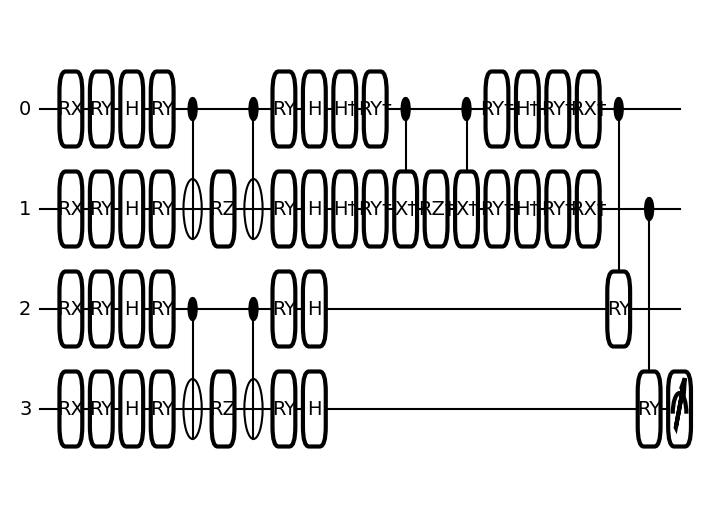

In [4]:
num_para = 5
#Block-encoding + Hardware-efficient Ansatz
def DataEncoding(x, wires_start, wires_end):
    wires = np.arange(wires_start, wires_end).tolist()
    qml.RX(x[0], wires=wires_start)
    qml.RX(x[1], wires=wires_start + 1)
    qml.RY(x[2], wires=wires_start)
    qml.RY(x[3], wires=wires_start + 1)
    #qml.AmplitudeEmbedding(features=x, wires=wires, pad_with=0., normalize=True)

def Ansatz(params, wires_start, wires_end):
    for i in np.arange(wires_start, wires_end):
        qml.Hadamard(wires=wires[i])
        qml.RY(params[i - wires_start], wires=wires[i])
    qml.CNOT(wires=[wires[wires_start], wires[wires_end - 1]])
    qml.RZ(params[wires_end - wires_start], wires=wires[wires_end - 1])
    qml.CNOT(wires=[wires_start, wires_end - 1])
    for i in np.arange(wires_start, wires_end):
        qml.RY(params[i + wires_end - 2 * wires_start], wires=wires[i])
        qml.Hadamard(wires=wires[i])

#@qml.qnode(dev, interface="torch", diff_method="parameter-shift")
@qml.qnode(dev)
def QKSAN(feat, params):
    x1 = feat[0:4]
    x2 = feat[4:8]
    DataEncoding(x1, 0, wire)
    Ansatz(params[0: num_para], 0, wire)
    qml.adjoint(Ansatz)(params[num_para: 2 * num_para], 0, wire)
    qml.adjoint(DataEncoding)(x2, 0, wire)


    DataEncoding(x2, wire, (2 * wire))
    Ansatz(params[2 * num_para: 3 * num_para], wire, (2 * wire))
    for i in range(wire):
        qml.cond(qml.measure(i), qml.RY)(params[3 * num_para + i], wires=wires[i + wire])
    return qml.expval(qml.PauliZ(2 * wire - 1))

qml.drawer.use_style('black_white')
fig, ax = qml.draw_mpl(QKSAN, show_all_wires=True)(feats_train[0], params_init)
fig.set_size_inches((7, 5))

def variational_classifier(params, feat):
    return QKSAN(feat, params)


def cost(params, features, labels):
    predictions = [variational_classifier(params, feat) for feat in features]
    return square_loss(labels, predictions)

lr = 0.06
def TrainQKSAN(params_init):
    opt = qml.NesterovMomentumOptimizer(lr)
    batch_size = 30
    weights = params_init
    #bias = np.array(0.0, requires_grad=True)
    his_acc_val = []
    his_acc_train = []
    his_cost = []
    f1_train = []
    f1_test = []
    roc_auc_train = []
    roc_auc_test = []
    for it in range(120):

        # Update the weights by one optimizer step
        batch_index = np.random.randint(0, 2 * train_size, (batch_size,))
        feats_train_batch = feats_train[batch_index]
        Y_train_batch = Y_train[batch_index]
        
        weights, _, _ = opt.step(cost, weights, feats_train_batch, Y_train_batch)

        # Compute predictions on train and validation set
        predictions_train = [np.sign(variational_classifier(weights, feat)) for feat in feats_train]
        predictions_val = [np.sign(variational_classifier(weights, feat)) for feat in feats_val]
        #print(probs(Y_train, predictions_val))
        c = cost(weights, features, Y).numpy()
        #print(c)
        # Compute accuracy on train and validation set
        acc_train = accuracy_score(Y_train, predictions_train)
        acc_val = accuracy_score(Y_val, predictions_val)
        a = f1_score(Y_train, predictions_train)
        b = f1_score(Y_val, predictions_val)
        
        print("f1_score is", a, b)
        d = roc_auc_score(Y_train, predictions_train)
        e = roc_auc_score(Y_val, predictions_val)
        print("roc_auc_score is", d, e)


        f1_train.append(a)
        f1_test.append(b)
        roc_auc_train.append(d)
        roc_auc_test.append(e)
        his_acc_val.append(acc_val)
        his_acc_train.append(acc_train)
        his_cost.append(c)
        print("Iter: {:5d} | Cost: {:0.7f} | Acc train: {:0.7f} | Acc validation: {:0.7f} "
            "".format(it + 1, c, acc_train, acc_val))
        
    return his_acc_val, his_acc_train, his_cost, f1_train, f1_test, roc_auc_train, roc_auc_test

In [5]:
lear_rate = [0.07, 0.08, 0.09]
a = []
b = []
c = []
for lr in lear_rate:
    a1, a2, a3, _, _, _, _, = TrainQKSAN(params_init)
    a.append(a1)
    b.append(a2)
    c.append(a3)
print(a)
print(b)
print(c)


f1_score is 0.4781609195402299 0.6013986013986014
roc_auc_score is 0.319 0.43
Iter:     1 | Cost: 1.1229454 | Acc train: 0.3190000 | Acc validation: 0.4300000 
f1_score is 0.3575525812619503 0.512396694214876
roc_auc_score is 0.32800000000000007 0.41
Iter:     2 | Cost: 1.0762492 | Acc train: 0.3280000 | Acc validation: 0.4100000 
f1_score is 0.017064846416382253 0.0
roc_auc_score is 0.424 0.44
Iter:     3 | Cost: 1.0352543 | Acc train: 0.4240000 | Acc validation: 0.4400000 
f1_score is 0.0 0.0
roc_auc_score is 0.5 0.5
Iter:     4 | Cost: 1.0049388 | Acc train: 0.5000000 | Acc validation: 0.5000000 
f1_score is 0.0 0.0
roc_auc_score is 0.5 0.5
Iter:     5 | Cost: 0.9769832 | Acc train: 0.5000000 | Acc validation: 0.5000000 
f1_score is 0.0 0.0
roc_auc_score is 0.5 0.5
Iter:     6 | Cost: 0.9410911 | Acc train: 0.5000000 | Acc validation: 0.5000000 
f1_score is 0.05058365758754864 0.0392156862745098
roc_auc_score is 0.512 0.51
Iter:     7 | Cost: 0.8930512 | Acc train: 0.5120000 | Acc v